In [1]:
import sys
sys.path.append('../')

import yaml
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, SkyOffsetFrame, EarthLocation, AltAz

from matplotlib import pyplot

from srcsim.mc import MCCollection
from srcsim.src import generator as srcgen
from srcsim.run import DataRun

# Simulation

Global configuration defining what will be simulated

In [2]:
cfg = yaml.load(open('run_example.yaml', "r"), Loader=yaml.FullLoader)

### MC file

In [3]:
file_name = 'dl2_gamma-diffuse_20deg_180deg_20201125_v0.6.3_prod5_v00_testing.h5'
# file_name = "dl2_gamma-diffuse_testing.h5"

max_samples = 100

In [4]:
mc = MCCollection(file_name)
mc.samples = mc.samples[:max_samples]
mc

MCCollection instance
    File mask...........: dl2_gamma-diffuse_20deg_180deg_20201125_v0.6.3_prod5_v00_testing.h5
    Obs IDs.............: (1002, 1005, 1008, 1009, 100, 1010, 1012, 1014, 1017, 1019, 101, 1023, 1025, 1029, 102, 1030, 1033, 1036, 1037, 1042, 1043, 1045, 1046, 1047, 1049, 104, 1054, 1059, 1060, 1065, 1069, 106, 1071, 1073, 1074, 1076, 107, 1080, 1082, 1083, 1086, 1088, 1089, 108, 1091, 1094, 1096, 1097, 1099, 10, 1100, 1101, 1102, 1106, 110, 1110, 1111, 1116, 1117, 1118, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 112, 1130, 1131, 1132, 1134, 1135, 1138, 1139, 1140, 1141, 1143, 1144, 1146, 1148, 114, 1150, 1151, 1154, 1158, 1162, 1164, 1165, 1166, 1169, 1170, 1173, 1176, 1177, 1178, 1179, 1180)



### Source

In [5]:
srcs = srcgen(cfg['sources'])
srcs

GaussSource instance
    Name................: source
    Position............: <SkyCoord (ICRS): (ra, dec) in deg
    (83., 22.)>
    Sigma...............: 0.3 deg

DiskSource instance
    Name................: source
    Position............: <SkyCoord (ICRS): (ra, dec) in deg
    (83., 20.)>
    Radius..............: 0.3 deg

IsotropicSource instance
    Name................: source
    Position............: <SkyCoord (ICRS): (ra, dec) in deg
    (83., 20.)>



### Data "run"

Can define a run by hand...

In [6]:
# #Can define a run by hand...
# lst_loc = EarthLocation(lat=28.761758*u.deg, lon=-17.890659*u.deg, height=2200*u.m)
# run = DataRun(
#     SkyCoord(83, 21, unit='deg', frame='icrs'),
#     Time('2022-05-31T15:00:00'),
#     Time('2022-05-31T15:20:00'),
#     lst_loc
# )

... but better take the settings from the specified configuration.

In [7]:
run = DataRun.from_config(cfg['run'])
run

DataRun instance
    Tel. RA/Dec.........: <SkyCoord (ICRS): (ra, dec) in deg
    (83., 21.)>
    Tstart..............: 2022-05-31T15:00:00.000
    Tstop...............: 2022-05-31T15:20:00.000
    Tel. azimuth........: [239.30 deg - 248.48 deg]
    Tel. alt............: [76.00 deg - 72.05 deg]



### Simulation...

In [8]:
evt = [
    run.predict(
        mc,
        src,
        tel_pos_tolerance=180*u.deg
    )
    for src in srcs
]
events = pd.concat(evt)

/usr/lib/python3/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


# Ploting the simulated events

In [9]:
lst_focal_length = 29.5 * u.m
cam2angle = 1 * u.rad / lst_focal_length
cam_x, cam_y = events[['src_x', 'src_y']].to_numpy().transpose() * u.m * cam2angle

In [10]:
tel_pos = run.tel_pos
frame = AltAz(
    obstime=Time(events['dragon_time'], format='unix'),
    location=run.obsloc
)

tel_pos = run.tel_pos.transform_to(frame)

offset_frame = SkyOffsetFrame(
    origin=tel_pos.altaz.skyoffset_frame().origin,
    location=tel_pos.altaz.frame.location,
    obstime=tel_pos.altaz.frame.obstime
)

coords = SkyCoord(
    events['src_x'].to_numpy() * u.m * cam2angle,
    events['src_y'].to_numpy() * u.m * cam2angle,
    frame=offset_frame
)

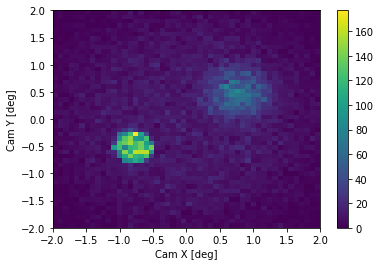

In [11]:
pyplot.xlabel('Cam X [deg]')
pyplot.ylabel('Cam Y [deg]')
pyplot.hist2d(
    cam_x.to('deg').value,
    cam_y.to('deg').value,
    range=(
        (-2, 2),
        (-2, 2)
    ),
    bins=50
);
pyplot.colorbar()

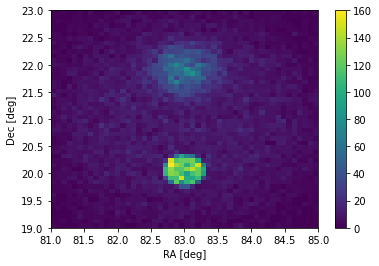

In [16]:
pyplot.xlabel('RA [deg]')
pyplot.ylabel('Dec [deg]')
pyplot.hist2d(
    coords.icrs.ra.to('deg').value,
    coords.icrs.dec.to('deg').value,
    range=[
        (run.tel_pos.ra.to('deg').value - 2, run.tel_pos.ra.to('deg').value + 2),
        (run.tel_pos.dec.to('deg').value - 2, run.tel_pos.dec.to('deg').value + 2)
    ],
    bins=50
);
pyplot.colorbar()

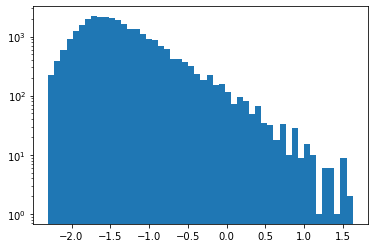

In [13]:
pyplot.semilogy()
pyplot.hist(
    np.log10(events['mc_energy']),
    # np.log10(mcevents.samples[0].data_table['mc_energy']),
    bins=50
);

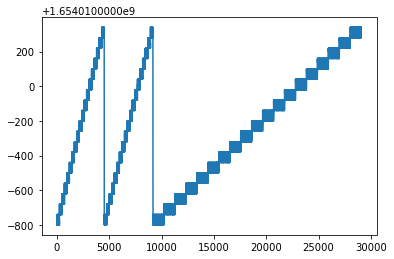

In [14]:
pyplot.plot(
    events['dragon_time'].to_numpy(),
)